In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize']=12,7

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
train.head(5)

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales
0,1,1,1,Development,Course,0,1,1,11004,0.007,81
1,2,2,1,Development,Course,0,0,1,13650,0.007,79
2,3,3,1,Development,Course,0,0,1,11655,0.007,75
3,4,4,1,Development,Course,0,0,1,12054,0.007,80
4,5,5,1,Development,Course,0,0,1,6804,0.007,41


In [3]:
from datetime import datetime,timedelta

In [4]:
train['ds']=pd.Timestamp('2020-03-29')
test['ds']=pd.Timestamp('2020-03-29')

In [5]:
train['Day_No']=pd.to_timedelta(train['Day_No'],unit='D')

In [6]:
test['Day_No']=pd.to_timedelta(test['Day_No'],unit='D')

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   ID                  36000 non-null  int64          
 1   Day_No              36000 non-null  timedelta64[ns]
 2   Course_ID           36000 non-null  int64          
 3   Course_Domain       36000 non-null  object         
 4   Course_Type         36000 non-null  object         
 5   Short_Promotion     36000 non-null  int64          
 6   Public_Holiday      36000 non-null  int64          
 7   Long_Promotion      36000 non-null  int64          
 8   Competition_Metric  35880 non-null  float64        
 9   ds                  36000 non-null  datetime64[ns] 
dtypes: datetime64[ns](1), float64(1), int64(5), object(2), timedelta64[ns](1)
memory usage: 2.7+ MB


In [7]:
train['ds']=train['ds']+train['Day_No']

In [8]:
test['ds']=test['ds']+test['Day_No']

In [9]:
test['ds']

0       2022-08-29
1       2022-08-30
2       2022-08-31
3       2022-09-01
4       2022-09-02
           ...    
35995   2022-10-23
35996   2022-10-24
35997   2022-10-25
35998   2022-10-26
35999   2022-10-27
Name: ds, Length: 36000, dtype: datetime64[ns]

In [10]:
train.head()

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales,ds
0,1,1 days,1,Development,Course,0,1,1,11004,0.007,81,2020-03-30
1,2,2 days,1,Development,Course,0,0,1,13650,0.007,79,2020-03-31
2,3,3 days,1,Development,Course,0,0,1,11655,0.007,75,2020-04-01
3,4,4 days,1,Development,Course,0,0,1,12054,0.007,80,2020-04-02
4,5,5 days,1,Development,Course,0,0,1,6804,0.007,41,2020-04-03


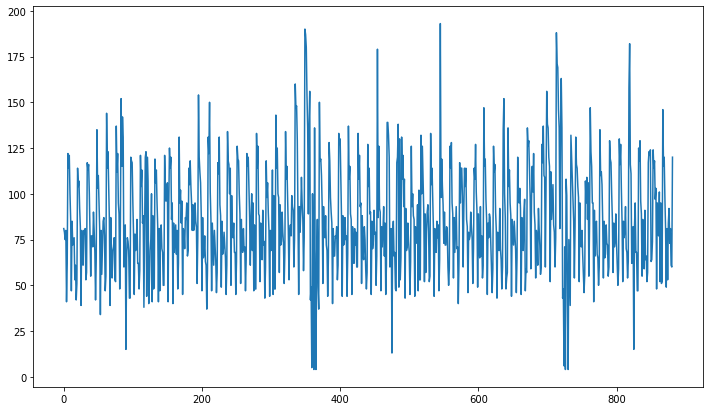

In [13]:
train[train['Course_ID']==1]['Sales'].plot()

In [104]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [14]:
train['y']=train['User_Traffic']

In [16]:
train.head()

,ID,Day_No,Course_ID,Course_Domain,Course_Type,Short_Promotion,Public_Holiday,Long_Promotion,User_Traffic,Competition_Metric,Sales,ds,y
0,1,1 days,1,Development,Course,0,1,1,11004,0.007,81,2020-03-30,11004
1,2,2 days,1,Development,Course,0,0,1,13650,0.007,79,2020-03-31,13650
2,3,3 days,1,Development,Course,0,0,1,11655,0.007,75,2020-04-01,11655
3,4,4 days,1,Development,Course,0,0,1,12054,0.007,80,2020-04-02,12054
4,5,5 days,1,Development,Course,0,0,1,6804,0.007,41,2020-04-03,6804


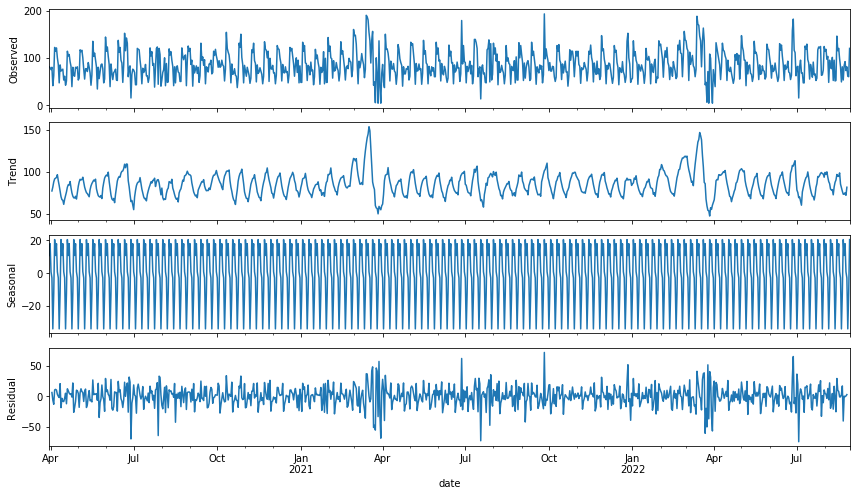

In [105]:
result=seasonal_decompose(train[train['Course_ID']==1]['Sales']).plot();

In [11]:
from fbprophet import Prophet

In [12]:
from sklearn.linear_model import Lasso

In [16]:
xpred=pd.DataFrame()
for i in train['Course_ID'].unique():
    X_train=train[train['Course_ID']==i]
    X_test=test[test['Course_ID']==i]
    m=Prophet()
    m.add_regressor('Short_Promotion')
    m.add_regressor('Public_Holiday')
    m.fit(train[['ds','y','Short_Promotion','Public_Holiday']])
    future=m.make_future_dataframe(periods=60,freq='D')
    future['Short_Promotion']=X_test['Short_Promotion']
    future['Public_Holiday']=X_test['Public_Holiday']
    forecast=m.predict(future)
    model=Lasso()
    model.fit(X_train[['User_Traffic']],X_train[['Sales']])
    preds=model.predict(forecast[['yhat']])
    pred1=pd.DataFrame(preds,columns='Sales'.split())
    xpred=xpred.append(pred1)
    xpred= xpred.reset_index(drop=True)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ValueError: Found NaN in column 'Short_Promotion'

In [129]:
xpred.tail()

,Sales
35995,176.259243
35996,161.039748
35997,160.561164
35998,157.089730
35999,170.191400


In [135]:
val1=test['ID'].values
val2=xpred['Sales'].values

In [138]:
len(val2)

36000

In [139]:
fin=pd.DataFrame({'ID':val1,'Sales':val2})

In [141]:
fin.head()

,ID,Sales
0,883,116.182894
1,884,121.992683
2,885,107.773222
3,886,100.864196
4,887,52.280676


In [142]:
fin.to_csv('SARIMAXPRED.csv',index=False)